<a href="https://colab.research.google.com/github/shadenWq/sentiment-analysis-/blob/main/Copy_of_Evaluation_of_RoBERTa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### The Dataset

Discover the dataset

In [ ]:
# Read the dataset
df = pd.read_csv('/content/Mental-Health-Twitter.csv')

In [ ]:
# Select only the needed columns
df = df[['Unnamed: 0', 'post_text', 'label']]

In [ ]:
df["sentiment label"] = df["label"].map({ 0 : 2, 1 : 0})

In [ ]:
df["label"] = df["label"].map({ 0 : 'non-depressed', 1 : 'depressed'})

In [ ]:
df.head()

,Unnamed: 0,post_text,label,sentiment label
0,0,It's just over 2 years since I was diagnosed w...,depressed,0
1,1,"It's Sunday, I need a break, so I'm planning t...",depressed,0
2,2,Awake but tired. I need to sleep but my brain ...,depressed,0
3,3,RT @SewHQ: #Retro bears make perfect gifts and...,depressed,0
4,4,It’s hard to say whether packing lists are mak...,depressed,0


## Pre-proccessing

In [ ]:
import nltk
import re #regular expression to clean data
from nltk.corpus import stopwords #stop word
nltk.download('stopwords') #corpus for stop words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

lemmatization

In [ ]:
import spacy

# Load the English model with spaCy's POS tagging from spaCy
modelspacy = spacy.load("en_core_web_sm")#load once

# Function to lemmatize text with spaCy
def lemmatize_text(text):
    # Process the text using spaCy, create Doc object
    docForLemmatization = modelspacy(text) #it includes tokenization and POS tagging

    # Lemmatize tokens, use "lemma_" attribute to get the lemma of each token
    lemmatized_tokens = [token.lemma_ for token in docForLemmatization]
    # and join them back into a single string
    return " ".join(lemmatized_tokens)

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [ ]:
def text_cleaning(text):

    text = text.lower() # Convert to lowercase

    text = re.sub(r'@[\S]+', '', text) # Remove usernames "sub" replacing substrings

    text = re.sub(r'https?://\S+|www\.\S+', '', text) # Remove hyperlinks

    text = re.sub('[^A-Za-z0-9]+', ' ', text) # Remove punctuation


    stop_words = set(stopwords.words('english')) # Remove stop words
    text = ' '.join([word for word in text.split() if word not in stop_words])

    text = lemmatize_text(text)# Lemmatize text

    return text

# use text cleaning function to create 'clean_text' column
df['clean_text'] = df['post_text'].apply(text_cleaning)

# Evaluation RoBERTa

In [ ]:
# library creates object for the dataset
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 38.7 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [ ]:
from datasets import Dataset # to create structured dataset from a CSV file
from datasets import DatasetDict # to create a dictionary to store training and testing dataset

In [ ]:
# Extracting the important features only
final_df = df[['clean_text', 'sentiment label']]

# Renaming the features so they're compatible with the HuggingFace Trainer
final_df.rename(columns={'clean_text': 'text', 'sentiment label': 'labels'}, inplace=True)

<ipython-input-26-50e62c569ca0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df.rename(columns={'clean_text': 'text', 'sentiment label': 'labels'}, inplace=True)


In [ ]:
from sklearn.model_selection import train_test_split
# Splitting the data and applying some necessary functions to make the data compatible with the Trainer from HuggingFace
train_data, test_data = train_test_split(final_df, test_size=0.2, shuffle=True, random_state=42)# random state to make sure that the dataset is always splitted the same, random_state=42 default value
test_data, val_data = train_test_split(test_data, test_size=0.5, shuffle=True, random_state=42) # validation set used during adjusting the hyperparameters

# reset the index to start from 0 to n
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)
val_data.reset_index(drop=True, inplace=True)

# Update the dataset structure to include the splits
# Create datasetDict object, Each dataset is converted from a Pandas DataFrame to a HuggingFace Dataset object using the 'from_pandas' method
dataset = DatasetDict({
    'train': Dataset.from_pandas(train_data),
    'validation': Dataset.from_pandas(val_data),
    'test': Dataset.from_pandas(test_data)
})

dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 2000
    })
})

In [ ]:
#reduce time
!pip install accelerate>=0.21.0

In [ ]:
import torch
from scipy.special import softmax
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from sklearn.metrics import f1_score, accuracy_score  #evaluation metrics

In [ ]:
#Pretrained model by huggingface
MODEL = "cardiffnlp/twitter-roberta-base-sentiment" #PretrainedModel
tokenizer = AutoTokenizer.from_pretrained(MODEL)  #tokenizer convert text to numerical tokens
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

# Function to tokenize the textual data before passing it to the model
def tokenize(examples):
  return tokenizer(examples['text'])
dataset = dataset.map(tokenize)


training_args = TrainingArguments(
    output_dir='./results', # the trained model is going to be saved in a directory names "results"
    logging_dir='./logs', #directory to save the logs: validation loss, training loss, metrics
    evaluation_strategy="steps",  # Evaluate every logging_steps
)

# The function that calulates the performance measures, in this case we used accuracy and f1 score
def compute_metrics(pred):
    labels = pred.label_ids # the true labels' ids from the dataset
    preds = pred.predictions.argmax(-1) #get the class for the highest probability predicted

    f1 = f1_score(labels, preds, average='weighted')
    accuracy = accuracy_score(labels, preds)
    return {'f1': f1, 'accuracy': accuracy}

# Combining all of the previous steps, data, model, hyperparameters, performance measures and tokenizer in order to start training
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
# Train
trainer.train()

Step,Training Loss,Validation Loss,F1,Accuracy
500,0.655500,0.631115,0.667391,0.676500
1000,0.594300,0.690755,0.723411,0.723500
1500,0.583600,0.636907,0.644471,0.644500
2000,0.633500,0.605836,0.713031,0.714000
2500,0.589300,0.678052,0.385335,0.509500
3000,0.581400,0.591628,0.699909,0.700500
3500,0.551600,0.601960,0.718508,0.718500
4000,0.532900,0.653994,0.723644,0.724500
4500,0.527000,0.573465,0.711670,0.719000
5000,0.504900,0.544967,0.736595,0.737500


TrainOutput(global_step=6000, training_loss=0.5585374908447266, metrics={'train_runtime': 688.4394, 'train_samples_per_second': 69.723, 'train_steps_per_second': 8.715, 'total_flos': 456485335169472.0, 'train_loss': 0.5585374908447266, 'epoch': 3.0})

# RoBERTa

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
#Pretrained model by roberta fine-tuning
tokenizer = AutoTokenizer.from_pretrained('/content/results/checkpoint-6000')
model = AutoModelForSequenceClassification.from_pretrained('/content/results/checkpoint-6000')

In [ ]:
def polarity_scores_roberta(example):
    encoded_text= tokenizer(example,return_tensors="pt") #Convert text into 0,1 so model can understand
    output = model(**encoded_text) #Going to run encoded values
    scores = output[0][0].detach().numpy() #Converting tensor to numpy
    scores = softmax(scores) #Normalizes the results
    #Create a new dictionary to store the results
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [ ]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['clean_text']
        myid = row['Unnamed: 0']
        res[myid] = polarity_scores_roberta(text)
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/20000 [00:00<?, ?it/s]

In [ ]:
robertas = pd.DataFrame(res).T
robertas = robertas.reset_index().rename(columns={'index': 'Unnamed: 0'})
robertas = robertas.merge(df, how='left')

In [ ]:
#Use lambda function to label tweets as positive, negative or neutral
robertas['Rob_Analysis'] = robertas.apply(lambda x:
                                          'Negative' if x['roberta_neg'] > x['roberta_pos']
                                                else ('Positive'),axis=1)

In [ ]:
robertas.head()

,Unnamed: 0,roberta_neg,roberta_neu,roberta_pos,post_text,label,sentiment label,clean_text,Rob_Analysis
0,0,0.874183,0.000024,0.125794,It's just over 2 years since I was diagnosed w...,depressed,0,2 year since diagnose anxiety depression today...,Negative
1,1,0.874187,0.000024,0.125789,"It's Sunday, I need a break, so I'm planning t...",depressed,0,sunday need break planning spend little time p...,Negative
2,2,0.874263,0.000024,0.125713,Awake but tired. I need to sleep but my brain ...,depressed,0,awake tired need sleep brain idea,Negative
3,3,0.874195,0.000024,0.125781,RT @SewHQ: #Retro bears make perfect gifts and...,depressed,0,rt retro bear make perfect gift great beginner...,Negative
4,4,0.874205,0.000024,0.125771,It’s hard to say whether packing lists are mak...,depressed,0,hard say whether pack list make life easy rein...,Negative


In [ ]:
#percentage of positive tweets
positiveTweets= robertas[robertas.Rob_Analysis=='Positive']
positiveTweets= round((positiveTweets.shape[0]/robertas.shape[0])*100,1)
positiveTweets

44.1

In [ ]:
#percentage of Negative tweets
NegativeTweets= robertas[robertas.Rob_Analysis=='Negative']
NegativeTweets= round((NegativeTweets.shape[0]/robertas.shape[0])*100,1)
NegativeTweets

55.9

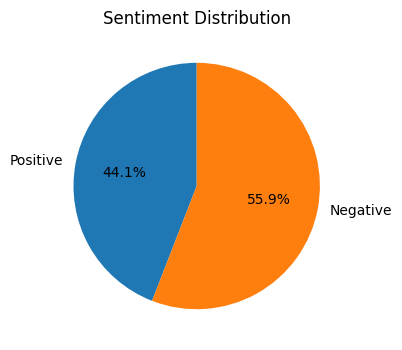

In [ ]:
# Sample data
labels = ['Positive', 'Negative']
sizes = [positiveTweets, NegativeTweets]  # These values should represent the percentages of each sentiment category

# Creating pie chart
plt.figure(figsize=(4, 4))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Sentiment Distribution')
plt.show()

<Axes: xlabel='label', ylabel='count'>

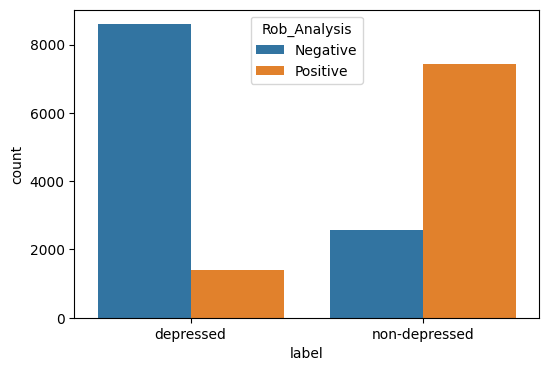

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(robertas, x="label", hue="Rob_Analysis")